## Time evaluation of the different policies

In [83]:
from SimulatorNN import Simulation, Vehicle, Client
from Utils import get_vehicle_assignment_nn
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch

from models import *
from evaluate_times import generate_event, generate_times, print_statistics

In [2]:
def show_statistics_time(total_info):
    f, ax = plt.subplots(2,2,figsize=(15,10), sharey=True)
    ax = ax.flatten()
    total_info.plot(kind='box', y='service_t_network', ax=ax[0])
    total_info.plot(kind='box', y='service_t_solution', ax=ax[1])
    ax[0].set_title('Service Time Net assignment')
    ax[1].set_title('Service Time Solution')

    total_info.plot(kind='box', y='travel_t_network', ax=ax[2])
    total_info.plot(kind='box', y='travel_t_solution', ax=ax[3])
    ax[2].set_title('Travel time Net assignment')
    ax[3].set_title('Travel time Solution')
    plt.show()
    

def results_comparison(total_info, cust1=0, cust2=10):
    # comparison of results
    simu = total_info[cust1:cust2]

    fig, ax = plt.subplots(figsize=(20,5))
    simu.plot(kind='scatter', x='arrival', y='ID', ax=ax, c='green')
    simu.plot(kind='scatter', x='pickup_t_network', y='ID', ax=ax, c='blue')
    simu.plot(kind='scatter', x='pickup_t_solution', y='ID', ax=ax, c='blue', marker='*', s=100)
    simu.plot(kind='scatter', x='dropoff_t_network', y='ID', ax=ax, c='black')
    simu.plot(kind='scatter', x='dropoff_t_solution', y='ID', ax=ax, c='black', marker = '*', s=100)

    #df_clients.iloc[1:10].plot(kind='scatter', x='max_time', y='ID', ax=ax, c='red')
    plt.legend(['Arrival', 'Pickup', 'Pickup - Solution', 'Dropoff', 'Dropoff - Solution'], loc=1)
    plt.grid()
    plt.title('10 customers ride times')
    plt.show()

def compute_obj(total_info, Event):
    return sum(total_info.delta_t_network), sum(v.ride_time for v in Event.vehicles)

def count_v(Event):
    cv = 0
    for v in Event.vehicles:
        if v.ride_time > 0:
            cv +=1
    return cv

### Evaluate performance of different models in terms of time 

We define:
- delta_time = dropoff time - client request arrival 
- travel_t = dropoff time - pickup time
- service_t = pickup time - client request arrival

In [3]:
TABLE = 8
NN = True

In [4]:
Event_base = generate_event(TABLE, 0, False, 0, 0)
df_clients_event_base, sol_event_base =  generate_times(Event_base)

In [5]:
delta_t_solution = sum(df_clients_event_base.delta_t)
ride_t_solution = sum(v.ride_time for v in Event_base.vehicles)

# Model 1. No extra info, only image.

In [6]:
model00 = torch.load('model_weights/model1_evaluation.pt')
model00.eval()
num_channels = 31
im_size = 30

Event00 = generate_event(TABLE, model00, NN, num_channels, im_size, single_output=True, single_input=True)
df_clients_event00, sol_event00 =  generate_times(Event00)
total_info00 = pd.merge(df_clients_event00, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

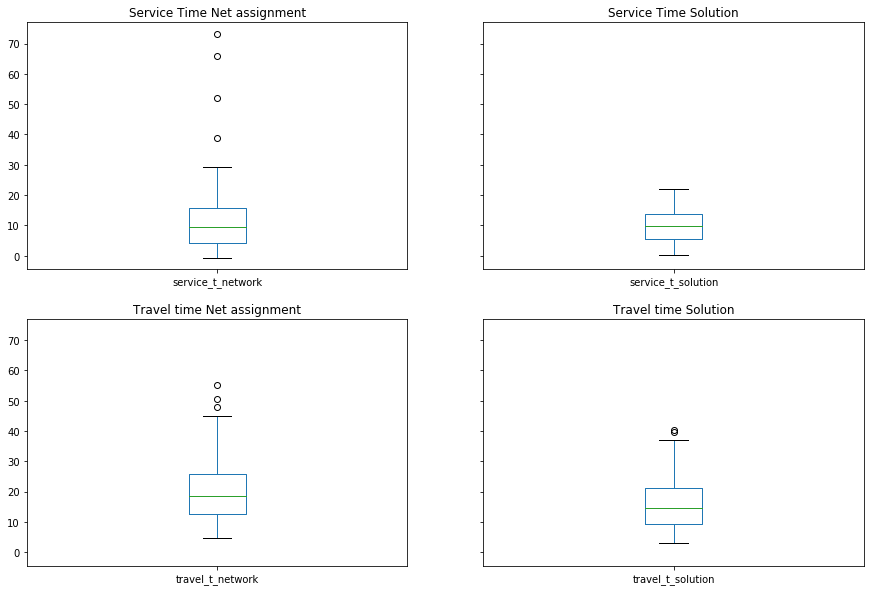

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 3099.956	Ride_t: 12844.672 	Objective: 15944.628	


In [7]:
show_statistics_time(total_info00)

delt00, ride00 = compute_obj(total_info00, Event00)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt00, ride00, delt00+ride00))



Num clients over max. service time: 11
Num clients over max. travel time: 6
--------------------------------- MAX 
Service time network: 73.300	Service time optimal policy 22.032	Difference service time 51.268
Travel  time network: 55.207	Travel  time optimal policy 40.397	Difference travel  time 14.810
Total   time network: 79.704	Total   time optimal policy 52.403	Difference travel   time 27.300
--------------------------------- MEAN 
Service time network: 12.056	Service time optimal policy 9.875	Difference service time 2.182
Travel  time network: 20.235	Travel  time optimal policy 16.022	Difference travel  time 4.213
Total   time network: 32.291	Total   time optimal policy 25.897	Difference travel   time 6.395
--------------------------------- MEDIAN 
Service time network: 9.579	Service time optimal policy 9.901	Difference service time -0.322
Travel  time network: 18.441	Travel  time optimal policy 14.416	Difference travel  time 4.025
Total   time network: 29.712	Total   time optima

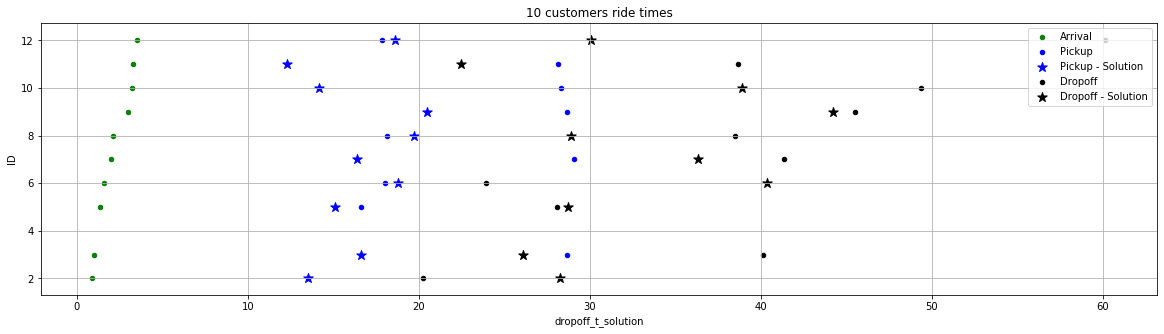

In [8]:
print_statistics(total_info00)
results_comparison(total_info00)

## Model 2. Double output; w=0.5

In [9]:
model2 = torch.load('model_weights/model2_evaluation.pt')
model2.eval()
num_channels = 31
im_size = 30

Event2 = generate_event(TABLE, model2, NN, num_channels, im_size, single_input=True)
df_clients_event2, sol_event2 =  generate_times(Event2)
total_info2 = pd.merge(df_clients_event2, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))

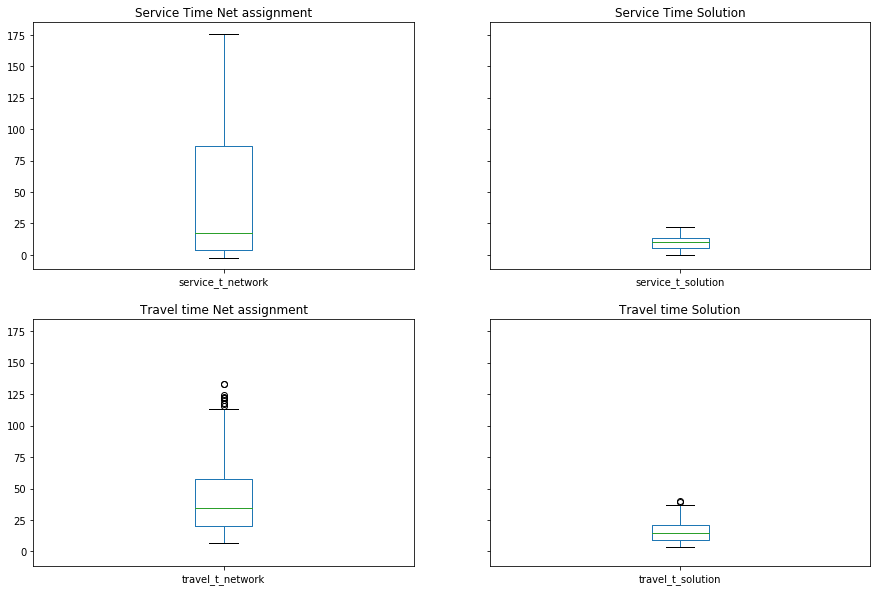

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294	


In [10]:
show_statistics_time(total_info2)

delt2, ride2 = compute_obj(total_info2, Event2)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt2, ride2, delt2+ride2))

Num clients over max. service time: 44
Num clients over max. travel time: 36
--------------------------------- MAX 
Service time network: 175.855	Service time optimal policy 22.032	Difference service time 153.824
Travel  time network: 133.132	Travel  time optimal policy 40.397	Difference travel  time 92.735
Total   time network: 202.290	Total   time optimal policy 52.403	Difference travel   time 149.887
--------------------------------- MEAN 
Service time network: 48.662	Service time optimal policy 9.875	Difference service time 38.787
Travel  time network: 45.510	Travel  time optimal policy 16.022	Difference travel  time 29.489
Total   time network: 94.172	Total   time optimal policy 25.897	Difference travel   time 68.275
--------------------------------- MEDIAN 
Service time network: 17.150	Service time optimal policy 9.901	Difference service time 7.248
Travel  time network: 34.566	Travel  time optimal policy 14.416	Difference travel  time 20.151
Total   time network: 102.712	Total   

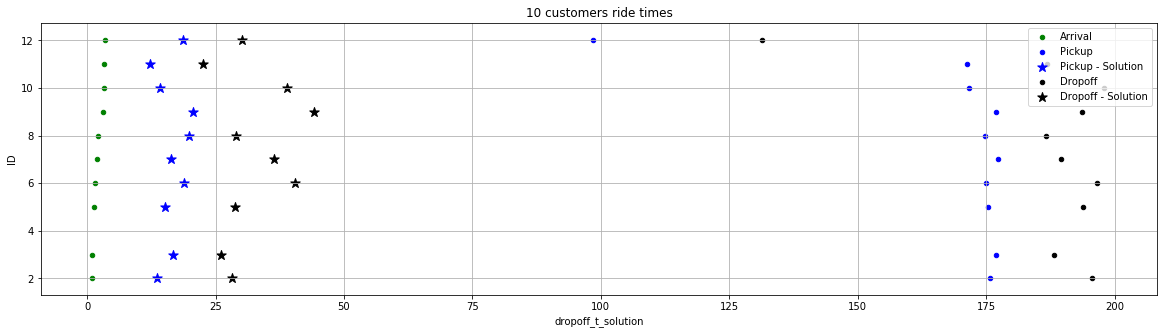

In [11]:
print_statistics(total_info2)
results_comparison(total_info2)

## Model 3. Double output; w=0.99

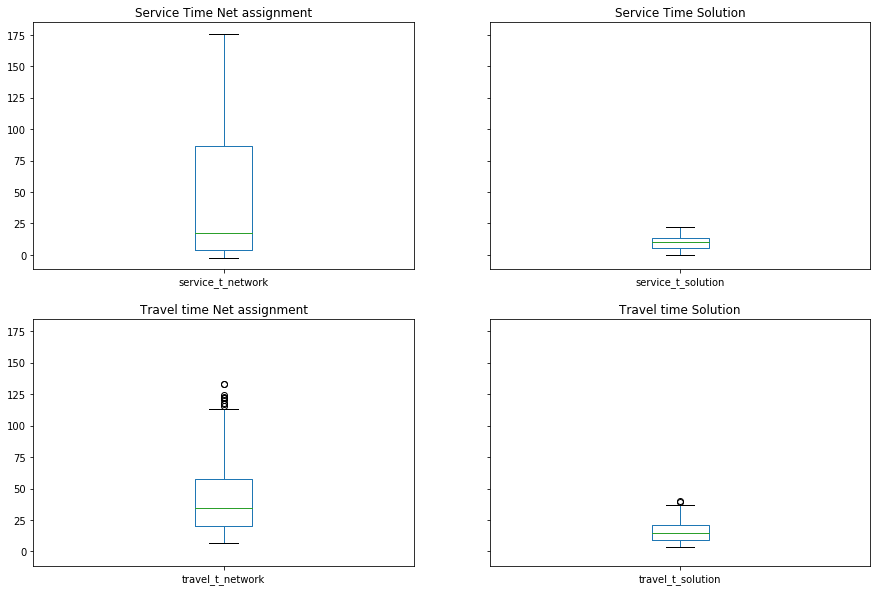

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294	
Num clients over max. service time: 44
Num clients over max. travel time: 36
--------------------------------- MAX 
Service time network: 175.855	Service time optimal policy 22.032	Difference service time 153.824
Travel  time network: 133.132	Travel  time optimal policy 40.397	Difference travel  time 92.735
Total   time network: 202.290	Total   time optimal policy 52.403	Difference travel   time 149.887
--------------------------------- MEAN 
Service time network: 48.662	Service time optimal policy 9.875	Difference service time 38.787
Travel  time network: 45.510	Travel  time optimal policy 16.022	Difference travel  time 29.489
Total   time network: 94.172	Total   time optimal policy 25.897	Difference travel   time 68.275
--------------------------------- MEDIAN 
Service time network: 17.150	Service time optimal policy 9.901	Difference service time 7.248
Travel  time netw

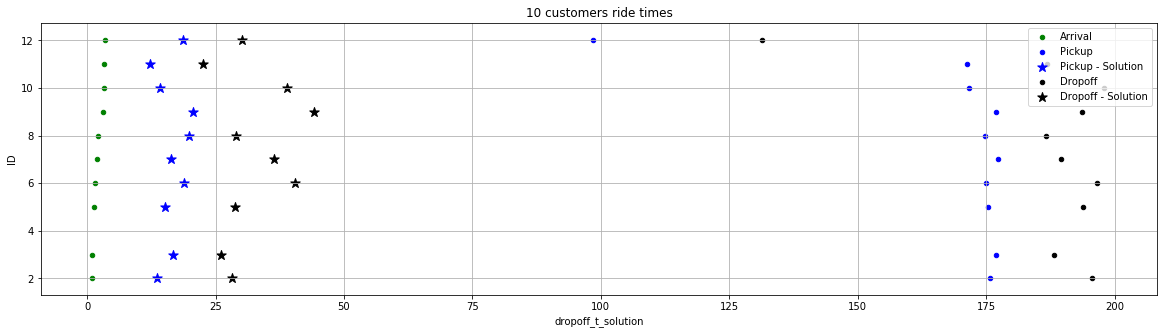

In [12]:
model3 = torch.load('model_weights/model3_evaluation.pt')
model3.eval()
num_channels = 31
im_size = 30

Event3 = generate_event(TABLE, model3, NN, num_channels, im_size, single_input=True)
df_clients_event3, sol_event3 =  generate_times(Event3)
total_info3 = pd.merge(df_clients_event3, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))
show_statistics_time(total_info3)

delt3, ride3 = compute_obj(total_info3, Event3)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt3, ride3, delt3+ride3))

print_statistics(total_info3)
results_comparison(total_info3)

## Model 4. Double Input Double output; w=0.99

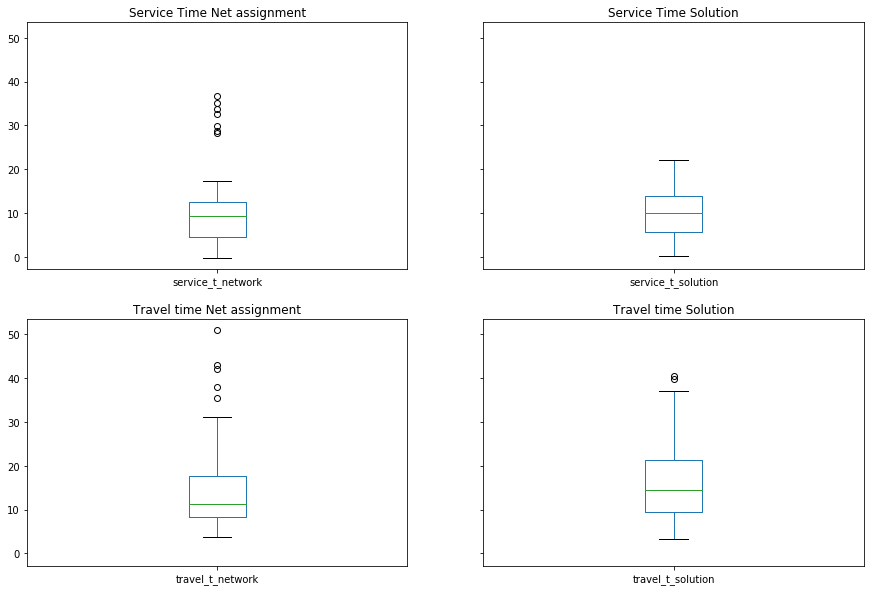

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 2294.749	Ride_t: 14969.749 	Objective: 17264.498	
Num clients over max. service time: 7
Num clients over max. travel time: 3
--------------------------------- MAX 
Service time network: 36.730	Service time optimal policy 22.032	Difference service time 14.698
Travel  time network: 50.948	Travel  time optimal policy 40.397	Difference travel  time 10.551
Total   time network: 59.034	Total   time optimal policy 52.403	Difference travel   time 6.631
--------------------------------- MEAN 
Service time network: 10.145	Service time optimal policy 9.875	Difference service time 0.270
Travel  time network: 13.759	Travel  time optimal policy 16.022	Difference travel  time -2.263
Total   time network: 23.904	Total   time optimal policy 25.897	Difference travel   time -1.993
--------------------------------- MEDIAN 
Service time network: 9.353	Service time optimal policy 9.901	Difference service time -0.548
Travel  time network: 11

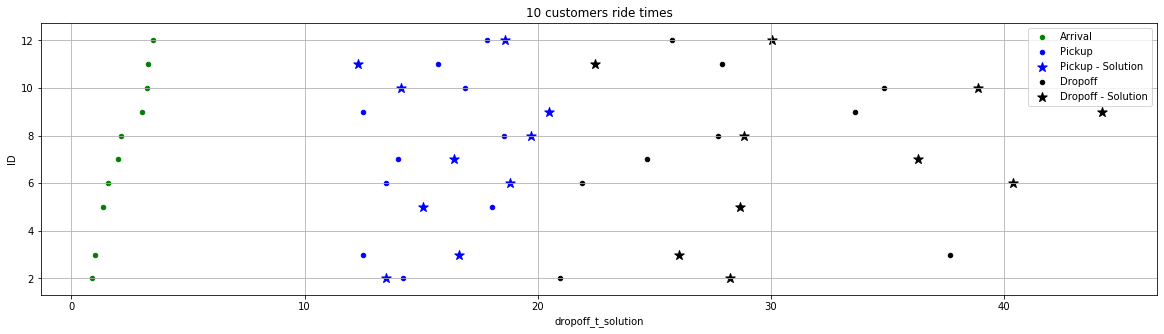

In [13]:
model4 = torch.load('model_weights2/model_size_30.pt')
model4.eval()
num_channels = 31
im_size = 30

Event4 = generate_event(TABLE, model4, NN, num_channels, im_size)
df_clients_event4, sol_event4 =  generate_times(Event4)
total_info4 = pd.merge(df_clients_event4, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))
show_statistics_time(total_info4)

delt4, ride4 = compute_obj(total_info4, Event4)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt4, ride4, delt4+ride4))

print_statistics(total_info4)
results_comparison(total_info4)

# Model 5. DIDO im size=50

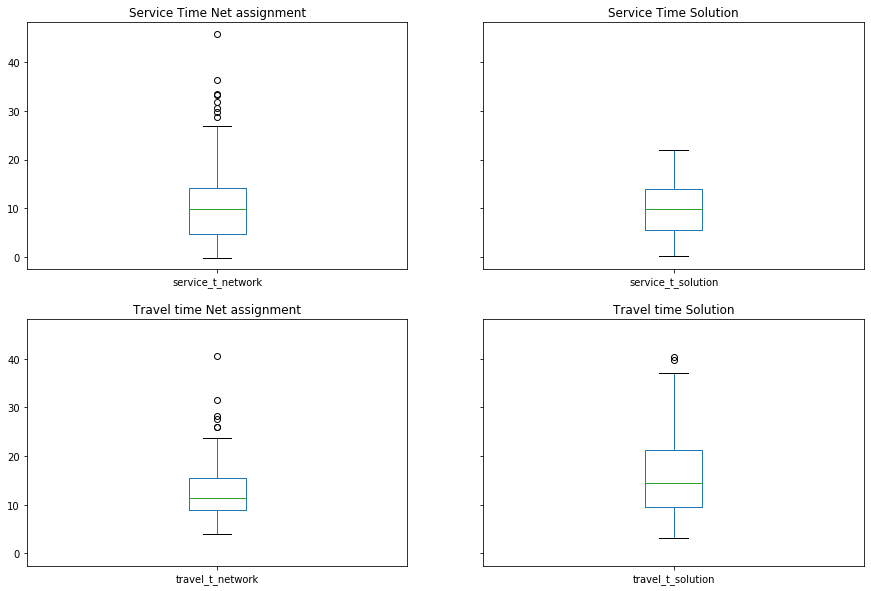

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 2289.723	Ride_t: 13990.731 	Objective: 16280.453	
Num clients over max. service time: 10
Num clients over max. travel time: 1
--------------------------------- MAX 
Service time network: 45.894	Service time optimal policy 22.032	Difference service time 23.863
Travel  time network: 40.465	Travel  time optimal policy 40.397	Difference travel  time 0.069
Total   time network: 53.455	Total   time optimal policy 52.403	Difference travel   time 1.052
--------------------------------- MEAN 
Service time network: 11.135	Service time optimal policy 9.875	Difference service time 1.260
Travel  time network: 12.717	Travel  time optimal policy 16.022	Difference travel  time -3.305
Total   time network: 23.851	Total   time optimal policy 25.897	Difference travel   time -2.045
--------------------------------- MEDIAN 
Service time network: 9.764	Service time optimal policy 9.901	Difference service time -0.138
Travel  time network: 11

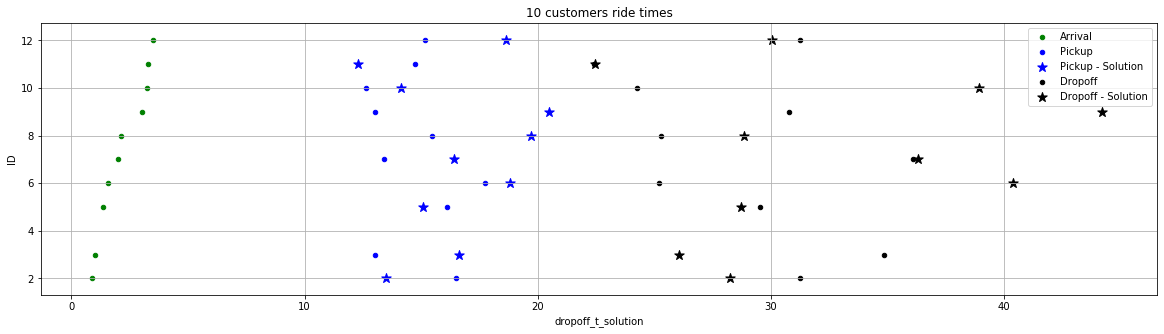

In [14]:
model5 = torch.load('model_weights2/model_size_50.pt')
model5.eval()
num_channels = 31
im_size = 50

Event5 = generate_event(TABLE, model5, NN, num_channels, im_size)
df_clients_event5, sol_event5 =  generate_times(Event5)
total_info5 = pd.merge(df_clients_event5, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))
show_statistics_time(total_info5)

delt5, ride5 = compute_obj(total_info5, Event5)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt5, ride5, delt5+ride5))

print_statistics(total_info5)
results_comparison(total_info5)

## Model 6. DIDO 2 channels

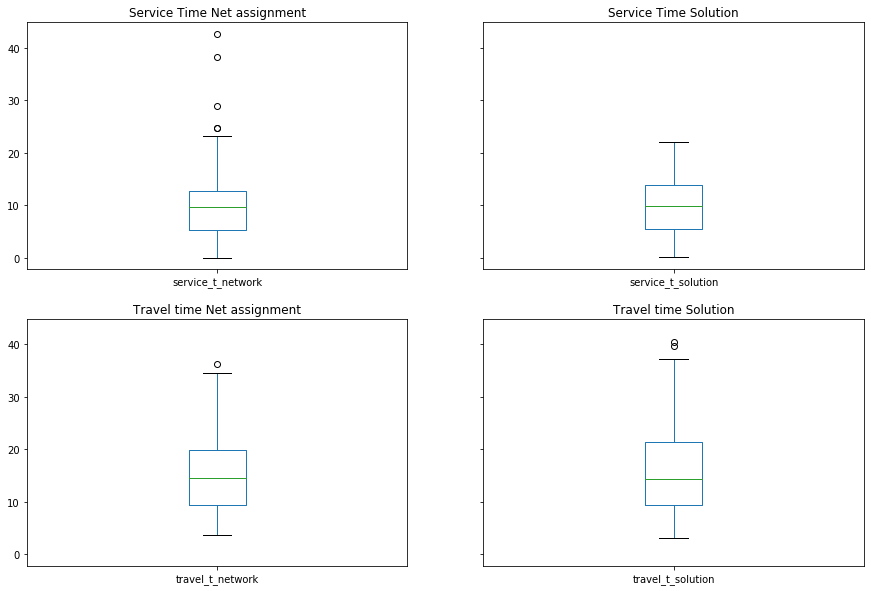

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 2490.417	Ride_t: 17809.422 	Objective: 20299.839	
Num clients over max. service time: 8
Num clients over max. travel time: 0
--------------------------------- MAX 
Service time network: 42.702	Service time optimal policy 22.032	Difference service time 20.670
Travel  time network: 36.313	Travel  time optimal policy 40.397	Difference travel  time -4.084
Total   time network: 58.923	Total   time optimal policy 52.403	Difference travel   time 6.520
--------------------------------- MEAN 
Service time network: 10.203	Service time optimal policy 9.875	Difference service time 0.328
Travel  time network: 15.739	Travel  time optimal policy 16.022	Difference travel  time -0.283
Total   time network: 25.942	Total   time optimal policy 25.897	Difference travel   time 0.045
--------------------------------- MEDIAN 
Service time network: 9.637	Service time optimal policy 9.901	Difference service time -0.264
Travel  time network: 14.

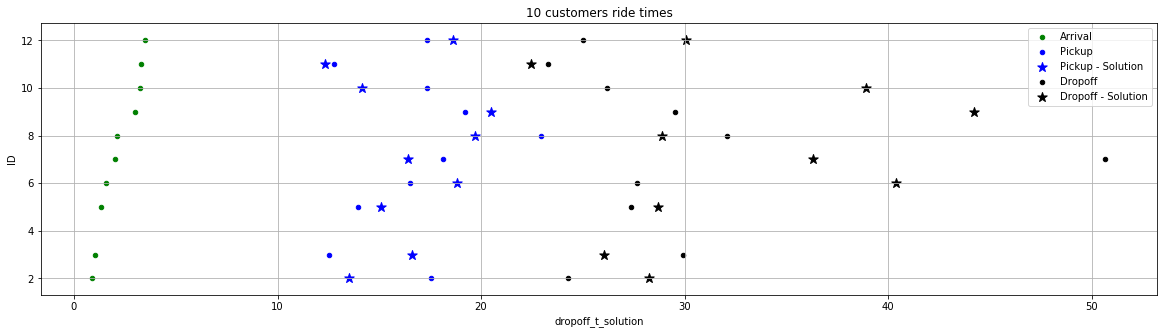

In [15]:
model6 = torch.load('model_weights/model6_evaluation.pt')
model6.eval()
num_channels = 2
im_size = 30

Event6 = generate_event(TABLE, model6, NN, num_channels, im_size)
df_clients_event6, sol_event6 =  generate_times(Event6)
total_info6 = pd.merge(df_clients_event6, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))
show_statistics_time(total_info6)

delt6, ride6 = compute_obj(total_info6, Event6)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt6, ride6, delt6+ride6))

print_statistics(total_info6)
results_comparison(total_info6)

## Model 7. DIDO 2 channels im_size=50

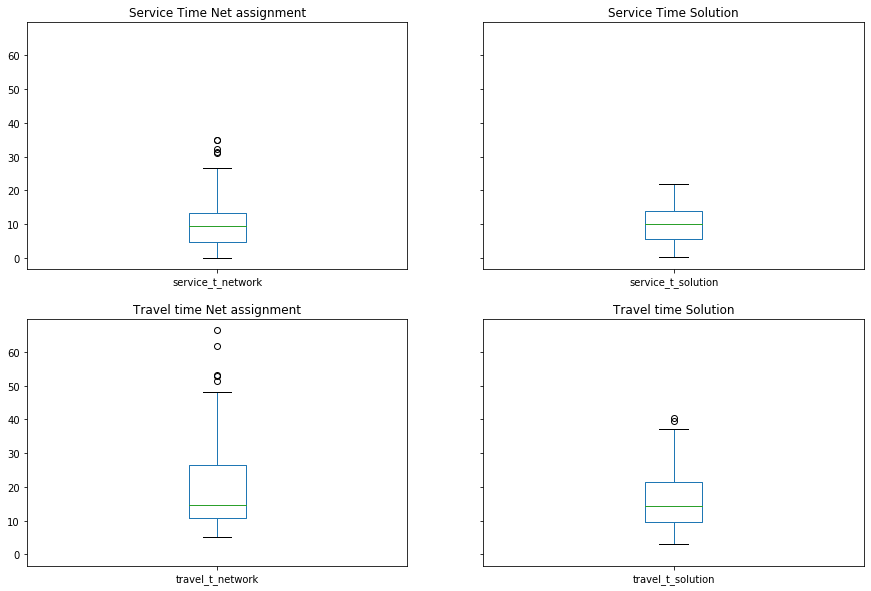

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 2911.944	Ride_t: 14008.073 	Objective: 16920.017	
Num clients over max. service time: 7
Num clients over max. travel time: 10
--------------------------------- MAX 
Service time network: 34.855	Service time optimal policy 22.032	Difference service time 12.824
Travel  time network: 66.500	Travel  time optimal policy 40.397	Difference travel  time 26.103
Total   time network: 67.679	Total   time optimal policy 52.403	Difference travel   time 15.276
--------------------------------- MEAN 
Service time network: 10.365	Service time optimal policy 9.875	Difference service time 0.490
Travel  time network: 19.968	Travel  time optimal policy 16.022	Difference travel  time 3.946
Total   time network: 30.333	Total   time optimal policy 25.897	Difference travel   time 4.436
--------------------------------- MEDIAN 
Service time network: 9.523	Service time optimal policy 9.901	Difference service time -0.378
Travel  time network: 14

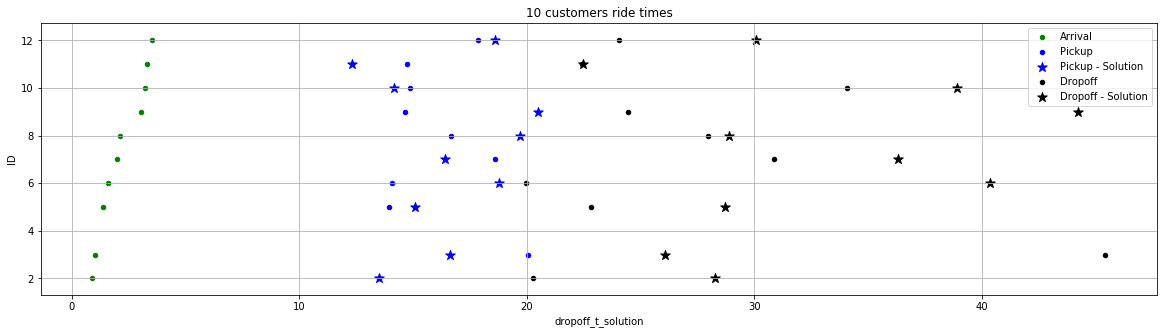

In [16]:
model7 = torch.load('model_weights/model7_evaluation.pt')
model7.eval()
num_channels = 2
im_size = 50

Event7 = generate_event(TABLE, model7, NN, num_channels, im_size)
df_clients_event7, sol_event7 =  generate_times(Event7)
total_info7 = pd.merge(df_clients_event7, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))
show_statistics_time(total_info7)

delt7, ride7 = compute_obj(total_info7, Event7)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt7, ride7, delt7+ride7))

print_statistics(total_info7)
results_comparison(total_info7)

# Model 8. 61 channels

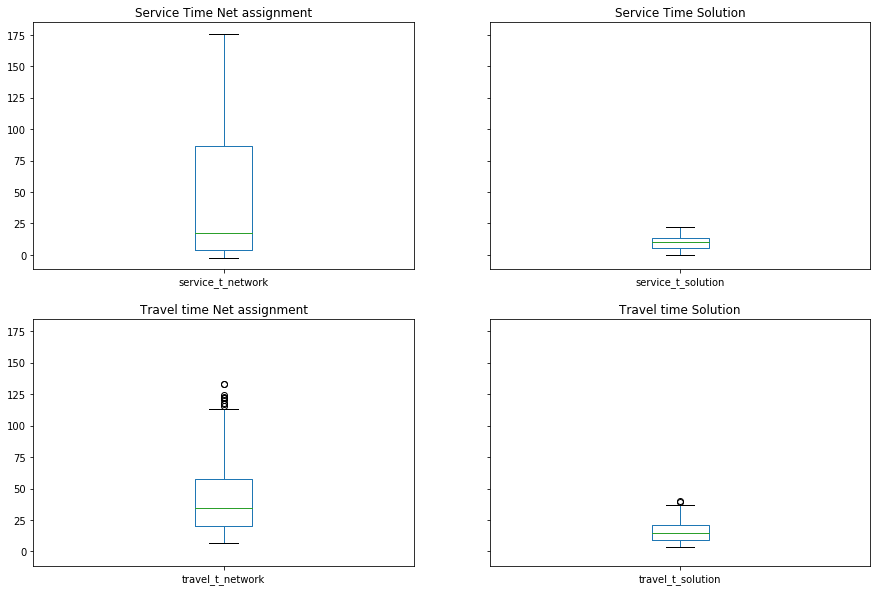

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	
Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294	
Num clients over max. service time: 44
Num clients over max. travel time: 36
--------------------------------- MAX 
Service time network: 175.855	Service time optimal policy 22.032	Difference service time 153.824
Travel  time network: 133.132	Travel  time optimal policy 40.397	Difference travel  time 92.735
Total   time network: 202.290	Total   time optimal policy 52.403	Difference travel   time 149.887
--------------------------------- MEAN 
Service time network: 48.662	Service time optimal policy 9.875	Difference service time 38.787
Travel  time network: 45.510	Travel  time optimal policy 16.022	Difference travel  time 29.489
Total   time network: 94.172	Total   time optimal policy 25.897	Difference travel   time 68.275
--------------------------------- MEDIAN 
Service time network: 17.150	Service time optimal policy 9.901	Difference service time 7.248
Travel  time netw

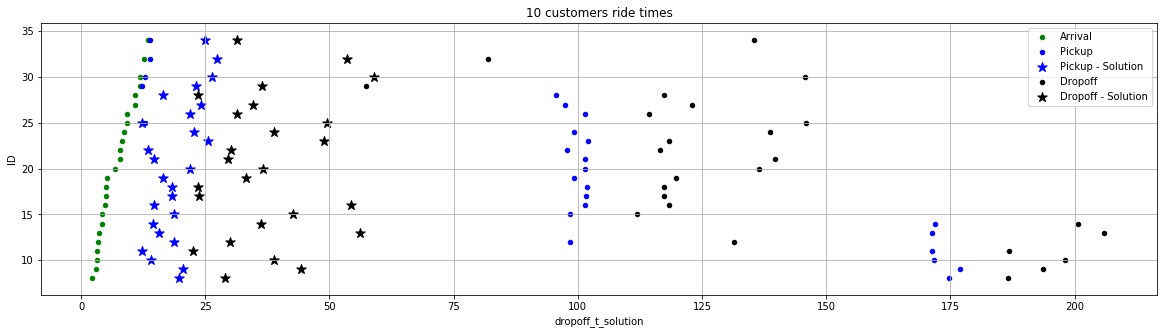

In [17]:
model8 = torch.load('clipped_weights.pt')
model8.eval()
num_channels = 61
im_size = 30

Event8 = generate_event(TABLE, model8, NN, num_channels, im_size)
df_clients_event8, sol_event8 =  generate_times(Event8)
total_info8 = pd.merge(df_clients_event8, df_clients_event_base, on=['ID', 'arrival'], suffixes=('_network','_solution'))
show_statistics_time(total_info8)

delt8, ride8 = compute_obj(total_info8, Event8)
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t'.format(delt8, ride8, delt8+ride8))

print_statistics(total_info8)
results_comparison(total_info8, 5, 30)

In [18]:
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f}\t Used vehicles {}'.format(delta_t_solution, ride_t_solution, delta_t_solution + ride_t_solution, count_v(Event_base)))
print('\n')
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f} \t Used vehicles {}'.format(delt00, ride00, delt00+ride00, count_v(Event00)))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f} \t Used vehicles {}'.format(delt2, ride2, delt2+ride2, count_v(Event2)))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f} \t Used vehicles {}'.format(delt3, ride3, delt3+ride3, count_v(Event3)))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f} \t Used vehicles {}'.format(delt4, ride4, delt4+ride4, count_v(Event4)))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f} \t Used vehicles {}'.format(delt5, ride5, delt5+ride5, count_v(Event5)))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f} \t Used vehicles {}'.format(delt6, ride6, delt6+ride6, count_v(Event6)))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f} \t Used vehicles {}'.format(delt7, ride7, delt7+ride7, count_v(Event7)))
print('Delta_t: {:.3f}\tRide_t: {:.3f} \tObjective: {:.3f} \t Used vehicles {}'.format(delt8, ride8, delt8+ride8, count_v(Event8)))

Delta_t: 2486.067	Ride_t: 14839.137 	Objective: 17325.204	 Used vehicles 17


Delta_t: 3099.956	Ride_t: 12844.672 	Objective: 15944.628 	 Used vehicles 14
Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294 	 Used vehicles 1
Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294 	 Used vehicles 1
Delta_t: 2294.749	Ride_t: 14969.749 	Objective: 17264.498 	 Used vehicles 21
Delta_t: 2289.723	Ride_t: 13990.731 	Objective: 16280.453 	 Used vehicles 22
Delta_t: 2490.417	Ride_t: 17809.422 	Objective: 20299.839 	 Used vehicles 20
Delta_t: 2911.944	Ride_t: 14008.073 	Objective: 16920.017 	 Used vehicles 19
Delta_t: 9040.513	Ride_t: 998.781 	Objective: 10039.294 	 Used vehicles 1


In [23]:
print('Travel time {:.3f}\n'.format(sum(df_clients_event_base.travel_t)))
print('Travel time {:.3f}'.format(sum(total_info00.travel_t_network)))
print('Travel time {:.3f}'.format(sum(total_info2.travel_t_network)))
print('Travel time {:.3f}'.format(sum(total_info3.travel_t_network)))
print('Travel time {:.3f}'.format(sum(total_info4.travel_t_network)))
print('Travel time {:.3f}'.format(sum(total_info5.travel_t_network)))
print('Travel time {:.3f}'.format(sum(total_info6.travel_t_network)))
print('Travel time {:.3f}'.format(sum(total_info7.travel_t_network)))
print('Travel time {:.3f}'.format(sum(total_info8.travel_t_network)))

Travel time 1538.088

Travel time 1942.547
Travel time 4368.991
Travel time 4368.991
Travel time 1320.870
Travel time 1220.809
Travel time 1510.959
Travel time 1916.883
Travel time 4368.991


In [24]:
print('service time {:.3f}\n'.format(sum(df_clients_event_base.service_t)))
print('service time {:.3f}'.format(sum(total_info00.service_t_network)))
print('service time {:.3f}'.format(sum(total_info2.service_t_network)))
print('service time {:.3f}'.format(sum(total_info3.service_t_network)))
print('service time {:.3f}'.format(sum(total_info4.service_t_network)))
print('service time {:.3f}'.format(sum(total_info5.service_t_network)))
print('service time {:.3f}'.format(sum(total_info6.service_t_network)))
print('service time {:.3f}'.format(sum(total_info7.service_t_network)))
print('service time {:.3f}'.format(sum(total_info8.service_t_network)))

service time 947.979

service time 1157.409
service time 4671.522
service time 4671.522
service time 973.879
service time 1068.914
service time 979.458
service time 995.060
service time 4671.522


In [88]:
matplotlib.rcParams.update({'font.size': 14})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


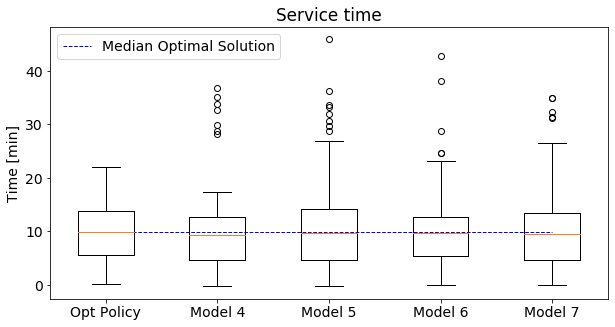

In [89]:
f, ax = plt.subplots(1, 1, figsize=(10,5))

ax.boxplot([list(df_clients_event_base.service_t), list(total_info4.service_t_network),\
            list(total_info5.service_t_network),list(total_info6.service_t_network), list(total_info7.service_t_network)], \
            labels=['Opt Policy', 'Model 4', 'Model 5', 'Model 6', 'Model 7'], positions = [0, 1, 2, 3, 4])

plt.plot([0, 1, 2, 3, 4], [np.median(list(df_clients_event_base.service_t))]*5, 'b--', \
         linewidth=1, label='Median Optimal Solution')
ax.set_ylabel('Time [min]')
ax.set_title('Service time')
plt.legend()
plt.savefig('service_time.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


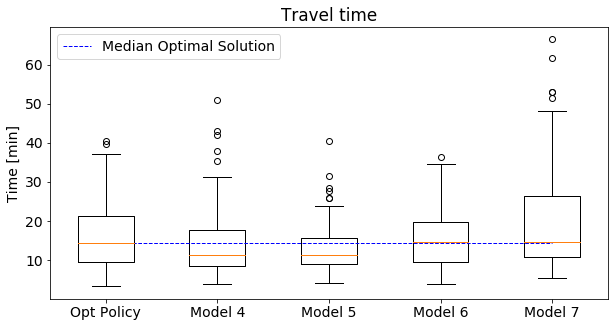

In [90]:
f, ax = plt.subplots(figsize=(10,5))
ax.boxplot([list(df_clients_event_base.travel_t), list(total_info4.travel_t_network),\
            list(total_info5.travel_t_network), list(total_info6.travel_t_network), list(total_info7.travel_t_network)], \
            labels=['Opt Policy', 'Model 4', 'Model 5', 'Model 6', 'Model 7'], positions = [0, 1, 2, 3, 4])

plt.plot([0, 1, 2, 3, 4], [np.median(list(df_clients_event_base.travel_t))]*5, 'b--', \
         linewidth=1, label='Median Optimal Solution')
ax.set_ylabel('Time [min]')
ax.set_title('Travel time')
plt.legend()
plt.savefig('travel_t.eps', bbox_inches='tight')
plt.show()

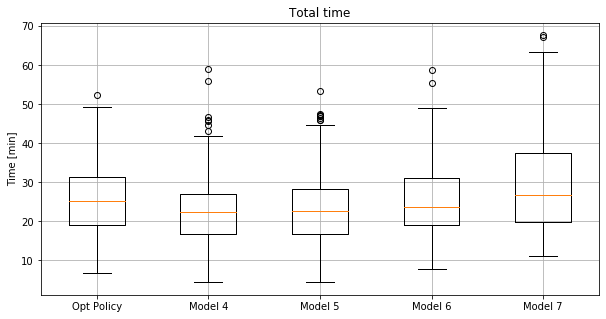

In [61]:
f, ax = plt.subplots(figsize=(10,5))
ax.boxplot([list(df_clients_event_base.delta_t), list(total_info4.delta_t_network),\
            list(total_info5.delta_t_network), list(total_info6.delta_t_network), list(total_info7.delta_t_network)], \
            labels=['Opt Policy', 'Model 4', 'Model 5', 'Model 6', 'Model 7'])
plt.plot([0, 1, 2, 3, 4], [np.median(list(df_clients_event_base.travel_t))]*5, 'b--', \
         linewidth=1, label='Median Optimal Solution')
ax.set_ylabel('Time [min]')
ax.set_title('Total time')

ax.grid(True)

#plt.savefig('delta_t.eps')
plt.show()